# Classification on toy trees

In [1]:
import seaborn as sns
import numpy as np
import os,sys
module_path = os.path.abspath(os.path.join('/Users/vayer/Documents/OT/Python/GW_tests/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graph import *
import copy


Le but de ce notebook est de présenter les résultats de classification de WGW sur des arbres et de voir en quoi on prend bien en compte la structure.

    - Comment les arbres sont-ils construits ?

Les arbres en question sont des arbres binaires. Ils sont construits de cette manière :
On créé un nombre de feuilles donné, multiple de 2. Les feuilles sont de deux types. Il y a les feuilles dont les attributs sont tirés selon une loi uniforme $\mathcal{U}(0,5)$ et l'autre type de feuille les attributs sont tirés selon une loi uniforme $\mathcal{U}(5,10)$ (ou autres paramètres mais pas de recouvrement). 
Ensuite on appareille les feuilles selon deux classes : une classe 0 dans laquelle les feuilles apparaillées proviennent de la même loi uniforme et l'autre classe 1 dans laquelle les feuilles appareillées proviennent des deux lois différents. L'attribut du noeud qui les appareille est la moyenne des atrributs des deux feuilles.

De cette manière un transport classique va transporter les feuilles d'une même loi sur les feuilles d'une même loi. Dans une classif avec un 1NN on va donc se tromper en gros une fois sur deux (ça dépend du nombre d'arbres aussi dans chaque classe). 

On va donc voir si WGW prend en compte cette structure.

In [21]:
graph=generate_binary_gaussian_tree(3,coupling='nocross')

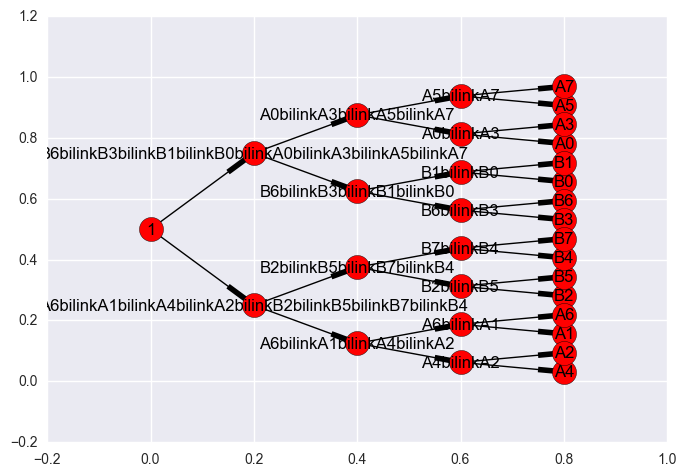

In [22]:
graph.display_graph(graph.tree,pos=graph.hierarchy_pos(graph.nx_graph,1,rotate=True))

In [23]:
dataset=build_binary_gaussian_dataset(nTree1=50,nTree2=50,maxdepth=3,c=20,d=30)

In [24]:
A,B=split_train_test(dataset,0.8)
x_train,y_train=zip(*A)
x_test,y_test=zip(*B)

In [25]:
x_train[0],y_train[0]

(<graph.Graph at 0x1116743c8>, 0)

In [26]:
x_train[1],y_train[1]

(<graph.Graph at 0x1113652b0>, 1)

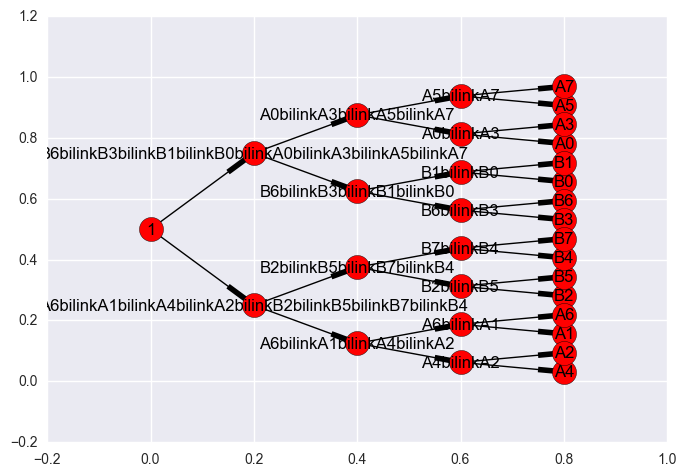

In [27]:
graph.display_graph(x_train[1].tree,pos=graph.hierarchy_pos(x_train[1].nx_graph,1,rotate=True))

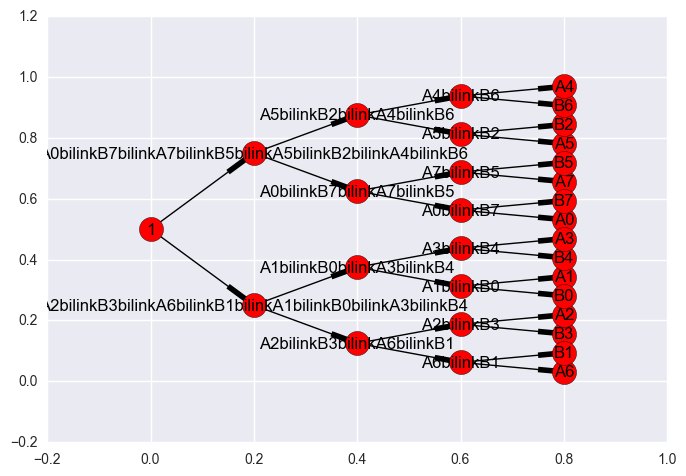

In [28]:
graph.display_graph(x_train[0].tree,pos=graph.hierarchy_pos(x_train[0].nx_graph,1,rotate=True))

In [11]:
x_train[1].nx_graph.nodes(data=1)

[(1, {}),
 ('B5', {'attr_name': 22.73958856392094}),
 ('B0bilinkB1', {}),
 ('A6bilinkA7bilinkB0bilinkB1', {}),
 ('B7', {'attr_name': 23.039135314484945}),
 ('B4', {'attr_name': 21.367096538946047}),
 ('B0', {'attr_name': 29.25187020152755}),
 ('A3bilinkA1bilinkB6bilinkB3', {}),
 ('A4', {'attr_name': 0.525350366835774}),
 ('A4bilinkA2bilinkB2bilinkB5', {}),
 ('B2bilinkB5', {}),
 ('A6', {'attr_name': 0.029996730519220027}),
 ('A7', {'attr_name': 2.7234607302137115}),
 ('B4bilinkB7bilinkA0bilinkA5', {}),
 ('A0bilinkA5', {}),
 ('A3bilinkA1', {}),
 ('A4bilinkA2bilinkB2bilinkB5bilinkA3bilinkA1bilinkB6bilinkB3', {}),
 ('B6', {'attr_name': 24.242856049645894}),
 ('A2', {'attr_name': 3.152926121024426}),
 ('A4bilinkA2', {}),
 ('A6bilinkA7', {}),
 ('B4bilinkB7', {}),
 ('B2', {'attr_name': 29.986034938228123}),
 ('A1', {'attr_name': 0.4131806688724876}),
 ('B6bilinkB3', {}),
 ('B1', {'attr_name': 23.065857373415533}),
 ('A6bilinkA7bilinkB0bilinkB1bilinkB4bilinkB7bilinkA0bilinkA5', {}),
 ('A3', {'

## 1NN classification

In [10]:
import NN,ot
import time

### Via EMD

In [13]:
local_metric=emd_tree_distance

In [14]:
one_nn=NN.Generic1NNClassifier(similarity_measure=local_metric,parallel=False,verbose=False,the_lower_the_better=True)

In [15]:
one_nn.fit(x_train,y_train)

Generic1NNClassifier(parallel=False, similarity_measure=None,
           the_lower_the_better=True, verbose=False)

In [16]:
start_time = time.time()
classes,similarities=one_nn.predict(x_test)
end_time = time.time()

In [17]:
print ("time to perform the preds: ",  end_time-start_time)

time to perform the preds:  6.800890922546387


In [18]:
np.sum(classes==y_test)/len(classes)

0.34999999999999998

On se trompe plus d'une fois sur deux

In [19]:
c,d=zip(*sorted( zip(y_test, similarities) ) )
e,f=zip(*sorted( zip(y_train, np.transpose(np.array(list(d))).tolist()) ) )

In [20]:
sim_ord=np.transpose(f)

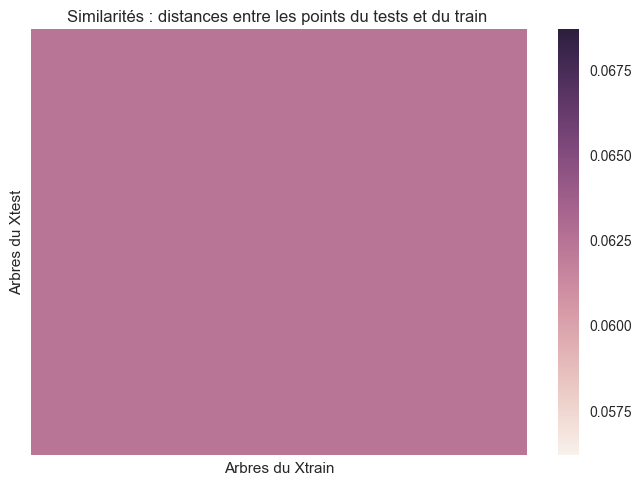

In [21]:
sns.heatmap(np.array(sim_ord),xticklabels=False,yticklabels=False)
plt.title('Similarités : distances entre les points du tests et du train ')
plt.xlabel('Arbres du Xtrain')
plt.ylabel('Arbres du Xtest')
plt.show()

Les distances sont identiques quelque soit la classe.

### Via WGW

In [12]:
import sys, os

# Disable
def blockPrint():
    print("This won't")
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    print('This will print')
    sys.stdout = sys.__stdout__

In [23]:
from sklearn.model_selection import StratifiedKFold

In [26]:
blockPrint()
start_time = time.time()
k_fold = StratifiedKFold(n_splits=2)
cv_scores = {}
for alpha in list(np.linspace(0,1500,4)):  
    for epsilon in list(np.linspace(0.01,50,3)): 
        start_time = time.time()
        clf = NN.Generic1NNClassifier(the_lower_the_better=True,similarity_measure=wgw_tree_distance(alpha,epsilon))
        l_scores = []
        for idx_subtrain, idx_valid in k_fold.split(x_train,y_train):
            x_subtrain = [x_train[i] for i in idx_subtrain]
            y_subtrain = [y_train[i] for i in idx_subtrain]
            x_valid=[x_train[i] for i in idx_valid]
            y_valid=[y_train[i] for i in idx_valid]
            pred = clf.fit(x_subtrain,y_subtrain).predict(x_valid)
            l_scores.append(np.sum(pred == y_valid) / len(y_valid))
        cv_scores[alpha, epsilon] = np.mean(l_scores)
        print("--- %s seconds ---" % (time.time() - start_time))
        print ("params :", alpha, epsilon, " accuracy :", np.mean(l_scores))

best_param1, best_param2 = utils.dict_argmax(cv_scores)

end_time = time.time()
#%%

In [32]:
best_param1,best_param2,dict_argmax(cv_scores)

(1000.0, 25.005000000000003, (1000.0, 25.005000000000003))

In [33]:
one_nn=NN.Generic1NNClassifier(similarity_measure=wgw_tree_distance(best_param1,best_param2),parallel=False,verbose=False,the_lower_the_better=False)

In [34]:
one_nn.fit(x_train,y_train)

Generic1NNClassifier(parallel=False, similarity_measure=None,
           the_lower_the_better=False, verbose=False)

In [35]:
start_time = time.time()
classes,similarities=one_nn.predict(x_test)
end_time = time.time()

In [36]:
print ("time to perform the preds: ",  end_time-start_time)

In [37]:
np.sum(classes==y_test)/len(classes)

0.34999999999999998

In [38]:
c,d=zip(*sorted( zip(y_test, similarities) ) )

In [39]:
e,f=zip(*sorted( zip(y_train, np.transpose(np.array(list(d))).tolist()) ) )

In [40]:
sim_ord=np.transpose(f)

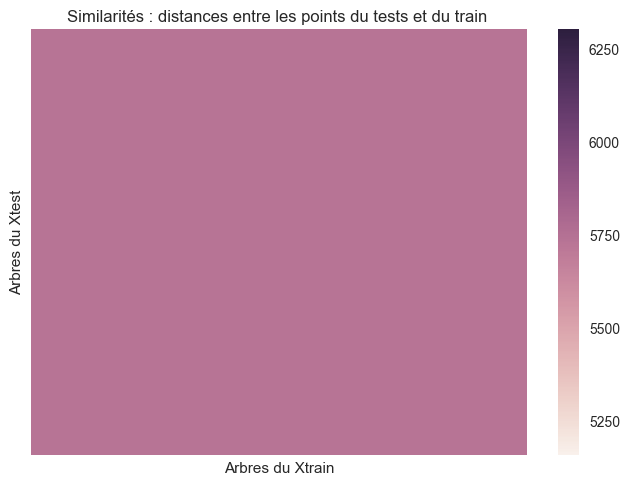

In [41]:
sns.heatmap(np.array(sim_ord),xticklabels=False,yticklabels=False)
plt.title('Similarités : distances entre les points du tests et du train ')
plt.xlabel('Arbres du Xtrain')
plt.ylabel('Arbres du Xtest')
plt.show()

Ca marche très mal : tous les points ont encore les mêmes distances. Mais c'est plutôt logique. Le coût shortest path utilisé est adéquat pour la structure binaire de l'arbre mais ici la structure de l'abre n'est pas le fait qu'il soit binaire ou non mais plus : 'est-ce que les feuilles appareillées sont issues d'une même loi uniforme ? '. Ce qui se traduit donc par un coût sur les attributs. 
On va donc définir un coût différent et pondérer le shortest path par quelque chose qui dépend des attributs.

On note $l(i,j)$ le shortest path de $i$ à $j$ et $a(i)$ l'attribut de i. 
On définit $$C_{i,j}=l(i,j)*\frac{d(a(i),a(j))}{max_{i,j}(d(a(i),a(j))}$$

### Via WGW avec une nouvelle distance entre les noeuds

In [14]:
import seaborn as sns
import numpy as np
import os,sys
module_path = os.path.abspath(os.path.join('/Users/vayer/Documents/OT/Python/GW_tests/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from graph import *
import copy
import NN,time

In [2]:
dataset=build_binary_gaussian_dataset(nTree1=50,nTree2=50,maxdepth=3,c=20,d=30)
A,B=split_train_test(dataset,0.8)
x_train,y_train=zip(*A)
x_test,y_test=zip(*B)

In [10]:
alpha=5
epsilon=0.1
dist=wgw_tree_distance(alpha,epsilon,method='weighted_shortest_path')

In [15]:
clf = NN.Generic1NNClassifier(the_lower_the_better=True,similarity_measure=dist)
clf.fit(x_train,y_train)

Generic1NNClassifier(parallel=False, similarity_measure=None,
           the_lower_the_better=True, verbose=False)

In [16]:
start_time = time.time()
classes,similarities=clf.predict(x_test)
end_time = time.time()

In [17]:
print ("time to perform the preds: ",  end_time-start_time)

time to perform the preds:  619.9233071804047


In [18]:
np.sum(classes==y_test)/len(classes)

0.75

In [19]:
c,d=zip(*sorted( zip(y_test, similarities) ) )
e,f=zip(*sorted( zip(y_train, np.transpose(np.array(list(d))).tolist()) ) )
sim_ord=np.transpose(f)

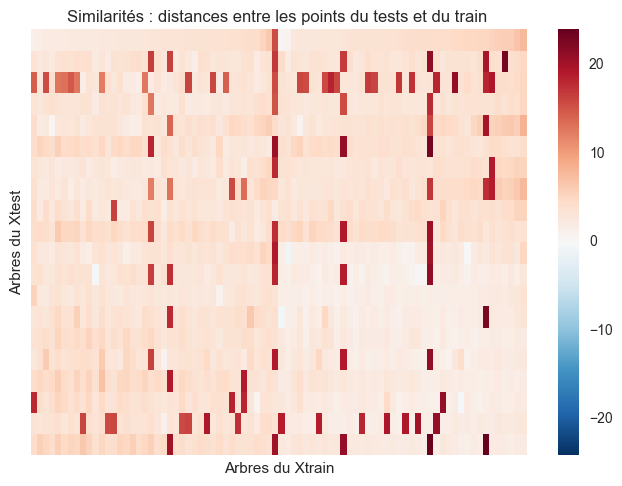

In [20]:
sns.heatmap(np.array(sim_ord),xticklabels=False,yticklabels=False)
plt.title('Similarités : distances entre les points du tests et du train ')
plt.xlabel('Arbres du Xtrain')
plt.ylabel('Arbres du Xtest')
plt.show()

C'est mieux mais c'est long, très long à cause du terme $max(d(a(i),a(j)))$.
On peut imaginer un autre coût voir même apprendre le coût à la manière de ground learning metric : notre L est différentiable. On peut considérer par exemple que le coût est une fonction des attribut et de la matrice d'adjacence et différentier selon ça ?

### Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
blockPrint()
start_time = time.time()
k_fold = StratifiedKFold(n_splits=2)
cv_scores = {}
for alpha in list(np.linspace(0,1500,4)):  
    for epsilon in list(np.linspace(0.01,50,3)): 
        start_time = time.time()
        clf = NN.Generic1NNClassifier(the_lower_the_better=True,similarity_measure=wgw_tree_distance(alpha,epsilon,method='weigthed_shortest_path'))
        l_scores = []
        for idx_subtrain, idx_valid in k_fold.split(x_train,y_train):
            x_subtrain = [x_train[i] for i in idx_subtrain]
            y_subtrain = [y_train[i] for i in idx_subtrain]
            x_valid=[x_train[i] for i in idx_valid]
            y_valid=[y_train[i] for i in idx_valid]
            pred = clf.fit(x_subtrain,y_subtrain).predict(x_valid)
            l_scores.append(np.sum(pred == y_valid) / len(y_valid))
        cv_scores[alpha, epsilon] = np.mean(l_scores)
        print("--- %s seconds ---" % (time.time() - start_time))
        print ("params :", alpha, epsilon, " accuracy :", np.mean(l_scores))

best_param1, best_param2 = utils.dict_argmax(cv_scores)

end_time = time.time()
#%%